# Model Debugging, Inspection, and Modularization

So far, you've focused on building and training models. 
But in the real world, your first attempt at a model rarely works perfectly. 
You'll often encounter cryptic error messages about mismatched tensor shapes, or worse, your model will run without errors but fail to produce meaningful results. 

This is where **debugging, inspection, and modularization** become essential skills. 
In this lab, you'll step into the role of a model investigator. 
You'll start with a broken Convolutional Neural Network (CNN) and use systematic debugging techniques to find and fix the bug. Then, you'll learn how to refactor your code for clarity and reuse, and finally, you'll dissect a complex, pre-trained model to understand its inner workings.

In this lab, you will:

* **Debug** a broken CNN by inserting print statements into the `forward` pass to identify and correct a critical tensor shape mismatch.
* **Refactor** the corrected model using `nn.Sequential` to create a cleaner, more modular, and less error-prone architecture.
* **Inspect** the activation statistics of your model to perform a sanity check for issues like exploding or vanishing gradients.
* **Explore** the architecture of a complex, pre-existing model (`SqueezeNet`) to count its layers and analyze its parameter distribution.

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import SqueezeNet

In [2]:
import helper_utils

## Data Loading

To debug and inspect a model effectively, you'll first need a dataset to work with.
The goal of this lab is to practice an end-to-end debugging and inspection workflow, so you'll use a simple dataset that lets you focus on the model architecture rather than complex data preprocessing.
For this purpose, you'll use the Fashion MNIST dataset, which consists of grayscale images of clothing items and serves as a straightforward benchmark for image classification tasks.
You’ll begin by loading the dataset using PyTorch’s torchvision library, and then create a DataLoader to efficiently handle the data in batches during training and evaluation.

In [3]:
dataset = helper_utils.get_dataset()

transform = transforms.ToTensor()
dataset.transform = transform

Dataset already exists.


In [4]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
img_batch, label_batch = next(iter(dataloader))
print("Batch shape:", img_batch.shape)  # Should be [batch_size, 1, 28, 28]

Batch shape: torch.Size([64, 1, 28, 28])


## Debugging through forward pass

When starting to work with a new model, it is common to encounter errors. 
These errors can be due to various reasons, such as incorrect tensor shapes, incompatible operations, or unexpected values.
Sometimes, the model may run without errors but produce incorrect outputs.

In this section, you will explore how to debug a PyTorch model by examining its forward pass.

### A first exploration of the model

It is now time to explore the model.
This model is a simple network with:
* a convolutional block: consisting of a convolutional layer, a ReLU activation function, and a max pooling layer,
* a fully connected block: consisting of a linear layer, a ReLU activation function, and a final linear layer that outputs the class scores.

You will first instantiate the model and try to run a forward pass with a batch from the dataloader.
To get a cleaner output in case of errors, you will use `try/except` to catch any exceptions that may arise during the forward pass.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for Fashion MNIST

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
simple_cnn = SimpleCNN()

try:
    output = simple_cnn(img_batch)  
except Exception as e:
    print(f"\033[91mError during forward pass: {e}\033[0m")

Error during forward pass: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


Indeed, the model as provided contains some errors that require debugging.
The message provided by PyTorch when an error occurs can sometimes be cryptic.
It describes that two matrices (`mat1` and `mat2`) cannot be multiplied and provides their shapes.
This indicates that there is a mismatch in the dimensions of the tensors being multiplied, which is a common issue in neural network implementations.

However, the error message does not specify **why and where** in the model the error occurs.
That is when the `forward` method of the model comes into play.
The dynamic graph nature of PyTorch allows you to insert print statements or use debugging tools to inspect the values and shapes of tensors at various points in the `forward` method.

You will define a new class that inherits from the original model and overrides the `forward` method to include print statements that display the shape of the tensor after each layer.
A first try might be to explicitly separate the layers in the `forward` method and, for each layer:
* print the shape of the tensor before the layer (input shape),
* print the shape of some *parameters of the layer* (e.g., weights and biases),
* print the shape of the *activation* tensor after the layer (output shape), which will be the input for the next layer.

You can now run the forward pass again and observe the printed shapes to identify where the mismatch occurs.

In [8]:
class SimpleCNNDebug(SimpleCNN):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN
        # No need to redefine the layers here

    def forward(self, x):
        print("Input shape:", x.shape)
        print(
            " (Layer components) Conv layer parameters (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activation) After convolution and ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activation) After pooling:", x_pool.shape)

        print(
            "(Layer components) Linear layer fc1 parameters (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_pool))

        print("===")

        print("(Activation) After fc1 and ReLU:", x_fc1.shape)

        print(
            "(Layer components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activation) After fc2 (output):", x.shape)
        return x

In [9]:
simple_cnn_debug = SimpleCNNDebug()

try:
    output_debug = simple_cnn_debug(img_batch)  
except Exception as e:
    print(f"\033[91mError during forward pass in debug model: {e}\033[0m")

Input shape: torch.Size([64, 1, 28, 28])
 (Layer components) Conv layer parameters (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activation) After convolution and ReLU: torch.Size([64, 32, 28, 28])
(Activation) After pooling: torch.Size([64, 32, 14, 14])
(Layer components) Linear layer fc1 parameters (weights, biases): torch.Size([128, 6272]) torch.Size([128])
Error during forward pass in debug model: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


This is already a cleaner output. You can already see that all the layers of the convolutional block are working fine, and the shapes are as expected (`batch_size=64` and `out_channels=32`).

**The error occurs in the fully connected block**, specifically at the first linear layer: `x_pool` has shape `[64, 32, 14, 14]`, but the linear layer expects an input of shape `[64, 6272]` (its weight matrix has shape `[128, 6272]`).

As the linear layer `fc1` expects a 2D input of shape `[batch_size, input_features]`, the `x_pool` is flattened to a 2D tensor with shape `[64*32*14, 14]` before being passed to `fc1`. This is not the intended shape, and it leads to the dimension mismatch error.

Once you have identified the issue, you can fix it by adding a flattening operation before the first linear layer in the `forward` method.

In [10]:
class SimpleCNNFixed(SimpleCNN):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print("Input shape:", x.shape)
        print(
            " (Neuron components) Conv layer parameters (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activation) After convolution and ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activation) After pooling:", x_pool.shape)

        x_flattened = torch.flatten(
            x_pool, start_dim=1
        )  # Flatten all dimensions except batch
        print("(Activation) After flattening:", x_flattened.shape)

        print(
            "(Neuron components) Linear layer fc1 parameters (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_flattened))

        print("===")

        print("(Activation) After fc1 and ReLU:", x_fc1.shape)

        print(
            "(Neuron components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activation) After fc2 (output):", x.shape)
        return x

In [11]:
# Fixed version
simple_cnn_fixed = SimpleCNNFixed()

output = simple_cnn_fixed(img_batch)

Input shape: torch.Size([64, 1, 28, 28])
 (Neuron components) Conv layer parameters (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activation) After convolution and ReLU: torch.Size([64, 32, 28, 28])
(Activation) After pooling: torch.Size([64, 32, 14, 14])
(Activation) After flattening: torch.Size([64, 6272])
(Neuron components) Linear layer fc1 parameters (weights, biases): torch.Size([128, 6272]) torch.Size([128])
===
(Activation) After fc1 and ReLU: torch.Size([64, 128])
(Neuron components) Linear layer fc2 parameters (weights, biases): torch.Size([10, 128]) torch.Size([10])
===
(Activation) After fc2 (output): torch.Size([64, 10])


The issue is now fixed, and the model runs without errors! You can see that the shapes of the tensors are as expected after each layer, and the final output has the correct shape of `[64, 10]`, corresponding to the batch size and the number of classes.

Once the model is running without errors, you can jump the next section to refactor the model using `nn.Sequential` for a cleaner and more modular implementation.

## `nn.Sequential` for Modularization

The model is now working correctly, but the `forward` method is quite verbose and repetitive.
To make the code cleaner and more modular, you can use `nn.Sequential` to define the convolutional and fully connected blocks.

In this way you gain several advantages:
* **Modularity**: Each block is defined as a separate module, making it easier to understand and modify.
* **Reusability**: You can easily reuse the blocks in other models or experiments.
* **Cleaner Code**: The `forward` method becomes much simpler, as it only needs to call the blocks sequentially.
* **Less Error-Prone**: By defining the blocks in one place, you reduce the chances of making mistakes when implementing the `forward` method.

In [12]:
class SimpleCNN2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        flattened_size = 32 * 14 * 14
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # 10 classes for Fashion MNIST
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_block(x)
        return x

In [13]:
simple_cnn_seq = SimpleCNN2Seq()
output = simple_cnn_seq(img_batch)

print("Output shape from sequential model:", output.shape)

Output shape from sequential model: torch.Size([64, 10])


### Statistical Inspection of the Initialization

A common check when inspecting a model is to look at the statistics of some activations to ensure that they are within a reasonable range.

In [14]:
class SimpleCNN2SeqDebug(SimpleCNN2Seq):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN2Seq
        # No need to redefine the layers here

    def get_statistics(self, activation):
        mean = activation.mean().item()
        std = activation.std().item()
        min_val = activation.min().item()
        max_val = activation.max().item()

        print(f" Mean: {mean}")
        print(f" Std: {std}")
        print(f" Min: {min_val}")
        print(f" Max: {max_val}")
        return mean, std, min_val, max_val

    def forward(self, x):
        features = self.conv_block(x)
        x = torch.flatten(features, start_dim=1)  # Flatten all dimensions except batch

        print("After conv_block, the activation statistics are:")
        self.get_statistics(features)

        x = self.fc_block(x)
        print("After fc_block, the activation statistics are:")
        self.get_statistics(x)
        return x

In [15]:
simple_cnn_seq_debug = SimpleCNN2SeqDebug()

for idx, (img_batch, _) in enumerate(dataloader):
    if idx < 5:
        print(f"=== Batch {idx} ===")
        output_debug = simple_cnn_seq_debug(img_batch)

=== Batch 0 ===
After conv_block, the activation statistics are:
 Mean: 0.15155267715454102
 Std: 0.2018119841814041
 Min: 0.0
 Max: 1.4487742185592651
After fc_block, the activation statistics are:
 Mean: -0.011871231719851494
 Std: 0.0561426505446434
 Min: -0.16812333464622498
 Max: 0.14432436227798462
=== Batch 1 ===
After conv_block, the activation statistics are:
 Mean: 0.15476031601428986
 Std: 0.20689530670642853
 Min: 0.0
 Max: 1.3940744400024414
After fc_block, the activation statistics are:
 Mean: -0.010677789337933064
 Std: 0.057223547250032425
 Min: -0.17939813435077667
 Max: 0.16999341547489166
=== Batch 2 ===
After conv_block, the activation statistics are:
 Mean: 0.1539902240037918
 Std: 0.2067674845457077
 Min: 0.0
 Max: 1.3845633268356323
After fc_block, the activation statistics are:
 Mean: -0.011626738123595715
 Std: 0.05525776371359825
 Min: -0.16323141753673553
 Max: 0.15786035358905792
=== Batch 3 ===
After conv_block, the activation statistics are:
 Mean: 0.15262

This is a sanity check to ensure that the model is initialized correctly and that the activations are not exploding or vanishing.
*Those issues can lead to poor training performance or convergence problems.*

## Model Inspection

With the previous model working correctly, you will now inspect a pre-existing complex model from `torchvision.models`, such as `SqueezeNet`.

In this section you will make use of the inspection utilities provided by PyTorch to explore the model's architecture, layers, and parameters.
These inspection techniques are foundational for effective debugging and for making informed modifications to your neural network designs.

### Architecture Overview

In [16]:
# Load SqueezeNet model
complex_model = SqueezeNet()

print(complex_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

For complex models, printing the entire model architecture can be overwhelming.
Instead, you can make use of `named_children()` and `children()` to iterate through the top-level blocks of the model.

In [17]:
# Iterate through the main blocks
for name, block in complex_model.named_children():
    print(f"Block {name} has a total of {len(list(block.children()))} layers:")
    
    # List all children layers in the block
    for idx, layer in enumerate(block.children()):
        # Check if the layer is terminal (no children) or not
        if len(list(layer.children())) == 0:
            print(f"\t {idx} - Layer {layer}")
        # If the layer has children, it's a sub-block, then print only the number of children and its name
        else:
            layer_name = layer._get_name()  # More user-friendly name
            print(f"\t {idx} - Sub-block {layer_name} with {len(list(layer.children()))} layers")            

Block features has a total of 13 layers:
	 0 - Layer Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
	 1 - Layer ReLU(inplace=True)
	 2 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 3 - Sub-block Fire with 6 layers
	 4 - Sub-block Fire with 6 layers
	 5 - Sub-block Fire with 6 layers
	 6 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 7 - Sub-block Fire with 6 layers
	 8 - Sub-block Fire with 6 layers
	 9 - Sub-block Fire with 6 layers
	 10 - Sub-block Fire with 6 layers
	 11 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 12 - Sub-block Fire with 6 layers
Block classifier has a total of 4 layers:
	 0 - Layer Dropout(p=0.5, inplace=False)
	 1 - Layer Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
	 2 - Layer ReLU(inplace=True)
	 3 - Layer AdaptiveAvgPool2d(output_size=(1, 1))


This provides a cleaner overview of the model's structure, allowing you to focus on the main components without getting lost in the details of every single layer.
You will now zoom into one of the `Fire` modules to see its internal structure.

For that you can use `modules()` to iterate through all the layers and sub-modules of the model.

In [18]:
first_fire_module = complex_model.features[3]

for idx, module in enumerate(first_fire_module.modules()):
    # Avoid printing the top-level module itself
    if idx > 0 :
        print(module)

Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)


Now the model's architecture is neatly printed, showing the main components and their configurations.
You can now do some specific inspections such as counting the number of specific layer types or calculating the total number of parameters in the model.

### Detail Inspection

You will now count how many `Conv2d` layers are in the model.

In [19]:
type_layer = nn.Conv2d

selected_layers = [layer for layer in complex_model.modules() if isinstance(layer, type_layer)]

print(f"Number of {type_layer.__name__} layers: {len(selected_layers)}")

Number of Conv2d layers: 26


You will now count the total number of parameters in the model.
This gives you an idea of the model's complexity and capacity.

In [20]:
# total number of parameters in the model
total_params = sum(p.numel() for p in complex_model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 1248424


Now, you can take this further by inspecting the parameters of each terminal layer (layers without children) in the model.
For each terminal layer, you will print its name and the total number of parameters it contains.
This helps to identify which layers contribute most to the model's parameter count and can be useful for model optimization, pruning, or understanding where the model's capacity lies.

Layer features.0 has 14208 parameters
Layer features.1 has 0 parameters
Layer features.2 has 0 parameters
Layer features.3.squeeze has 1552 parameters
Layer features.3.squeeze_activation has 0 parameters
Layer features.3.expand1x1 has 1088 parameters
Layer features.3.expand1x1_activation has 0 parameters
Layer features.3.expand3x3 has 9280 parameters
Layer features.3.expand3x3_activation has 0 parameters
Layer features.4.squeeze has 2064 parameters
Layer features.4.squeeze_activation has 0 parameters
Layer features.4.expand1x1 has 1088 parameters
Layer features.4.expand1x1_activation has 0 parameters
Layer features.4.expand3x3 has 9280 parameters
Layer features.4.expand3x3_activation has 0 parameters
Layer features.5.squeeze has 4128 parameters
Layer features.5.squeeze_activation has 0 parameters
Layer features.5.expand1x1 has 4224 parameters
Layer features.5.expand1x1_activation has 0 parameters
Layer features.5.expand3x3 has 36992 parameters
Layer features.5.expand3x3_activation has 

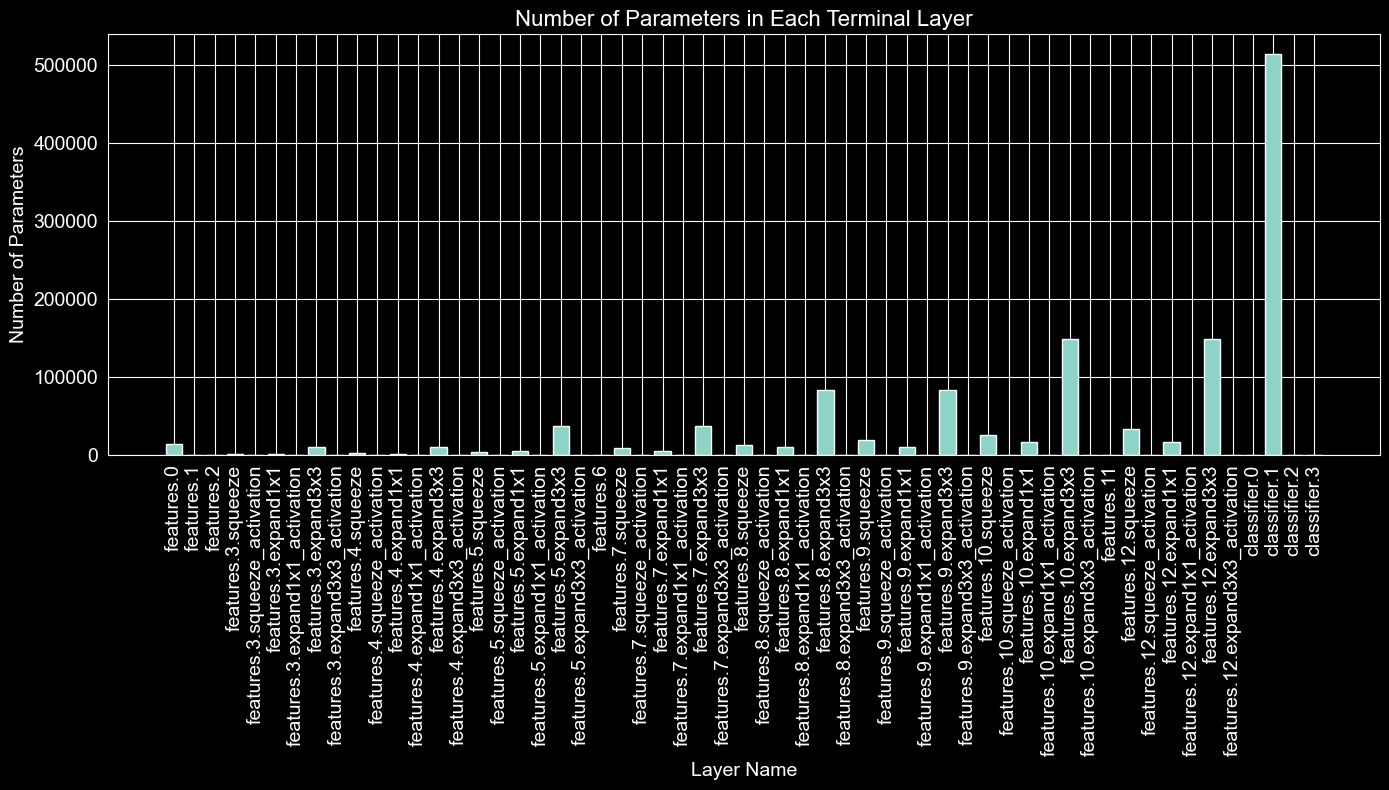

In [21]:
counting_params = {}

# For each terminal layer print its number of parameters
for layer in complex_model.named_modules():
    n_children = len(list(layer[1].children()))
    if n_children == 0:  # Terminal layer
        layer_name = layer[0]
        n_parameters = sum(p.numel() for p in layer[1].parameters())
        counting_params[layer_name] = n_parameters
        print(f"Layer {layer_name} has {n_parameters} parameters")

# Plotting the distribution of parameters per layer
helper_utils.plot_counting(counting_params)

# Conclusion

You have now successfully debugged, refactored, and inspected PyTorch models. 
In this lab, you saw firsthand that a model's `forward` pass is not a black box and that by strategically adding print statements, you can diagnose and solve common but frustrating errors like shape mismatches.

You have moved beyond simply writing model code and can now make it more robust and readable by grouping layers into logical blocks with **`nn.Sequential`**. 
This practice of modularization makes your architectures easier to understand, reuse, and adapt. 
You also learned how to perform essential sanity checks by inspecting activation statistics and how to systematically explore any PyTorch model, no matter how complex, using inspection utilities like `.modules()` and `.named_children()`.

With these fundamental skills of debugging and inspection, you are well-prepared for more advanced challenges.